# Plots

In [2]:
import h5py
import pandas as pd
import os
from shapely.geometry import Polygon
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoLocator, FuncFormatter
import matplotlib.colors as mcol
import matplotlib.ticker as ticker
font = {'family' : 'serif',
         'size'   : 26,
         'serif':  'cmr10'
         }
plt.rc('font', **font)
plt.rc('axes', unicode_minus=False)
plt.rcParams.update({'font.size': 26})
pd.options.mode.chained_assignment = None

from helper_functions.helper_functions import get_coords, pixels_between_points

import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

# Plan

Combine the plots below, size comparision, ml area error, IoU, etc into one large plot (or two).
Crop them somewhat to remove all the black areas, wasted space. Pick more high contrast colors, (the lines, etc)

Make plot with the granules at multiple IoU thresholds and ML error thresholds. Gives reader a frame of reference, 

Several granules have low IoU's indicating that the ML method performs poorly, visually inspecting these granules however tells a different story.
The Gradient method messes up its boundary, (due to the fourier modes estimating the border loosing information and estimating it in their own way.), often resulting in it creating strange artifacts, going outside the cropped image area, etc.



In [3]:
# Load all files
def get_csv_file_paths(training_results, name, remove_debug=False):
    full_paths = [training_results +'/'+ file for file in os.listdir(f"{training_results}") if file[-4:] != ".csv"]

    comp_df = pd.read_csv(full_paths[0], index_col=0)
    comp_df['file'] = pathlib.Path(full_paths[0]).stem
    for fpath in full_paths[1:]:
        read_df = pd.read_csv(fpath, index_col=0)
        read_df['file'] = pathlib.Path(fpath).stem
        comp_df = pd.concat((comp_df, read_df))
        
    return comp_df.reset_index(drop=True)

# Gradient
fourier_df = get_csv_file_paths("D:\Master\MasterProject\GE_result_analysis\comparison_results",    name="GRADIENT_CZ")
# Add unique identifier for each experiment
fourier_df['file_name'] = fourier_df['file'].str[:10] 
fourier_df['ML_area_error'] = fourier_df['area_ml'] / fourier_df['area_gradient']

fourier_df = fourier_df.dropna()

In [4]:
fourier_df[:3]

,granule_ids,frames,area_gradient,area_ml,IoU,gradient_mean_intensity,gradient_mean_radius,gradient_major_axis,gradient_minor_axis,gradient_eccentricity,...,ml_exlusive,gradient_exclusive,Gradient_valid,ML_valid,Granules_in_common_count,Gradient_exclusive_count,ML_exlusive_count,file,file_name,ML_area_error
0,1,0,84.402306,96.228079,0.716780,39266.144578,0.509116,1.209705,0.885146,0.681623,...,False,False,24,23,22,2,1,2019-10-31_10.49.52--NControlLongB--T1015-Burst,2019-10-31,1.140112
1,6,0,68.993446,94.720346,0.493384,31355.056338,0.453508,1.044949,0.905651,0.498840,...,False,False,24,23,22,2,1,2019-10-31_10.49.52--NControlLongB--T1015-Burst,2019-10-31,1.372889
2,8,0,57.635195,69.885397,0.620705,24385.116667,0.423685,0.958723,0.815494,0.525807,...,False,False,24,23,22,2,1,2019-10-31_10.49.52--NControlLongB--T1015-Burst,2019-10-31,1.212547


In [5]:
fourier_df.columns

Index(['granule_ids', 'frames', 'area_gradient', 'area_ml', 'IoU',
       'gradient_mean_intensity', 'gradient_mean_radius',
       'gradient_major_axis', 'gradient_minor_axis', 'gradient_eccentricity',
       'ml_mean_intensity', 'ml_mean_radius', 'ml_major_axis', 'ml_minor_axis',
       'ml_eccentricity', 'granules_is_common', 'ml_exlusive',
       'gradient_exclusive', 'Gradient_valid', 'ML_valid',
       'Granules_in_common_count', 'Gradient_exclusive_count',
       'ML_exlusive_count', 'file', 'file_name', 'ML_area_error'],
      dtype='object')

In [6]:
# fourier_df[fourier_df['ml_exlusive'] == True][]
# fourier_df[fourier_df['ml_exlusive'] == True]

In [7]:
fourier_df[(.4 < fourier_df['IoU']) & (fourier_df['IoU'] < .7)].sample(1000).to_csv("D:\Master\MasterProject\GE_result_analysis/test_above4_7.csv")

In [8]:
def plot_scatter_and_heatmap(colum_x, colum_y, x_axis_title, y_axis_title, filename, save=False, thousends=True, line=False):
    fig = plt.figure(layout="constrained", figsize=(12, 6),)
    subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

    axs0 = subfigs[0].subplots(1,1)

    # ---- Upper plot ----
    axs0.scatter(fourier_df[colum_x], fourier_df[colum_y], label=f"all experiments", rasterized=True) 
    axs0.legend(loc='lower left', fontsize=18)
    # axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
    if thousends:
        formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
    else:
        formatter = mpl.ticker.FuncFormatter(lambda x, pos: x)
    axs0.yaxis.set_major_formatter(formatter)
    # ---- Bottom three ----
    axs1 = subfigs[1].subplots(1, 3, sharex=True, sharey=True)
    for ax in axs1:
        formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
        ax.yaxis.set_major_formatter(formatter)

    # Lower left
    ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
    axs1[0].scatter(ex1_df[colum_x], ex1_df[colum_y], rasterized=True, label=f"2019-10-31", color='purple') 
    axs1[0].legend(loc='center left', fontsize=18)

    # Lower middle
    ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']
    axs1[1].scatter(ex3_df[colum_x], ex3_df[colum_y], rasterized=True, label=f"2019-12-09", color='orange') 
    axs1[1].legend(loc='center left', fontsize=18)

    # Lower right
    ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
    axs1[2].scatter(ex2_df[colum_x], ex2_df[colum_y], rasterized=True, label=f"2020-02-05", color='green') 
    axs1[2].legend(loc='center left', fontsize=18)

    if line:
        axs0.plot([0,2150], [0, 2150], label=f"", c='red')
        axs1[0].plot([0,2150], [0, 2150], label=f"", c='red')
        axs1[1].plot([0,2150], [0, 2150], label=f"", c='red')
        axs1[2].plot([0,2150], [0, 2150], label=f"", c='red')

    axs0.text(.02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes)
    axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes)
    axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes)
    axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes)

    # # Set common labels
    fig.supxlabel(x_axis_title)
    fig.supylabel(y_axis_title)
    if save:
        fig.savefig(f"D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/{filename}_scatter.svg")   
    fig.show()
    # ---------------------------------------------------------------------------------------------------------------
    # ------------------------------ HEATMAP ------------------------------
    fig = plt.figure(layout="constrained", figsize=(12, 6),)
    subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

    axs0 = subfigs[0].subplots(1,1)

    im0 = axs0.hist2d(fourier_df[colum_x], fourier_df[colum_y], label=f"ALL", bins=50, cmap=plt.colormaps["inferno"]) 
    fig.colorbar(im0[3], ax=axs0)
    # axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
    if thousends:
        formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.1fk' % (x * 1e-3))
    else:
        formatter = mpl.ticker.FuncFormatter(lambda x, pos: x)#'%1.1fk' % (x * 1e-3))
    axs0.yaxis.set_major_formatter(formatter)
    # ---- Bottom three ----
    axs1 = subfigs[1].subplots(1, 3,)# sharey=True)
    for ax in axs1:
        formatter = mpl.ticker.FuncFormatter(lambda x, pos: x)#'%1.1fk' % (x * 1e-3))
        ax.yaxis.set_major_formatter(formatter)


    ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
    ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
    ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']

    h1, _,_,_ = plt.hist2d(ex1_df['ML_area_error'], ex1_df['area_gradient'], bins=50)
    h2, _,_,_ = plt.hist2d(ex2_df['ML_area_error'], ex2_df['area_gradient'], bins=50)
    h3, _,_,_ = plt.hist2d(ex3_df['ML_area_error'], ex3_df['area_gradient'], bins=50)

    vmax = np.max((h1,h2,h3))

    # Lower left
    im00 = axs1[0].hist2d(ex1_df[colum_x], ex1_df[colum_y], label=f"2019-10-31", bins=50, cmap=plt.colormaps["inferno"], vmax=vmax) 
    # fig.colorbar(im00[3], ax=axs1)
    # axs1[0].legend(loc='upper right', fontsize=18)
    # axs1[0].set_aspect('auto')

    # # Lower middle
    im11 = axs1[1].hist2d(ex3_df[colum_x], ex3_df[colum_y], label=f"2019-12-09", bins=50, cmap=plt.colormaps["inferno"], vmax=vmax) 
    # axs1[1].legend(loc='upper right', fontsize=18)
    # axs1.set_aspect('auto')

    # # Lower right
    axs1[2].hist2d(ex2_df[colum_x], ex2_df[colum_y], label=f"2020-02-05", bins=50, cmap=plt.colormaps["inferno"], vmax=vmax) 
    # axs1[2].legend(loc='upper right', fontsize=18)
    # axs1[2].set_aspect('auto')

    if line:
        axs0.plot([0,2150], [0, 2150], label=f"", c='red'   , alpha=0.25)
        axs1[0].plot([0,2150], [0, 2150], label=f"", c='red', alpha=0.25)
        axs1[1].plot([0,2150], [0, 2150], label=f"", c='red', alpha=0.25)
        axs1[2].plot([0,2150], [0, 2150], label=f"", c='red', alpha=0.25)

    fig.colorbar(im00[3], ax=axs1)

    axs0.text(   .02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes   , color='white')
    axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes, color='white')
    axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes, color='white')
    axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes, color='white')

    axs0.text(   .890, .920, 'All experiments', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes,    color='white')
    axs1[0].text(.720, .925, '2019-10-31', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes, color='white')
    axs1[1].text(.720, .925, '2019-12-09', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes, color='white')
    axs1[2].text(.720, .925, '2020-02-05', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes, color='white')

    # # Set common labels
    fig.supxlabel(x_axis_title, fontsize=28)
    fig.supylabel(y_axis_title, fontsize=28)
    if save:
        fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/Granule_Area_error.svg")   
    fig.show()

In [9]:
# plot_scatter_and_heatmap(colum_x='ML_area_error', colum_y='mean_intensity', x_axis_title="ML area error", y_axis_title="Mean Intensity Area", filename="")
# plot_scatter_and_heatmap(colum_x='ML_area_error', colum_y='IoU', x_axis_title="ML area error", y_axis_title="IoU", filename="")

# Detected granules (with limitations, need to be revised)

In [9]:
count_gradient, count_ml = 0,0
for i, data in enumerate(fourier_df.groupby('file')):
    gradient_valid, ml_valid = data[1].iloc[0][['Gradient_valid', 'ML_valid']] # ,'Gradient_valid', 'ML_valid'
    # print(gradient_valid, ml_valid)
    count_gradient += gradient_valid 
    count_ml += ml_valid 

print("Gradient: ", count_gradient)
print("ML:       ", count_ml)
print(f"ML has {count_ml-count_gradient} more granules!")

Gradient:  15116
ML:        15514
ML has 398 more granules!


In [10]:
count_common, count_g_exlusive, count_ml_exlusive = 0,0,0
for i, data in enumerate(fourier_df.groupby('file')):
    common, g_exlusive, ml_exlusive = data[1].iloc[0][['Granules_in_common_count','Gradient_exclusive_count', 'ML_exlusive_count']] # ,'Gradient_valid', 'ML_valid'
    # print(gradient_valid, ml_valid)
    count_common += common
    count_g_exlusive += g_exlusive 
    count_ml_exlusive += ml_exlusive

print(f"{count_common} granules in common!")
print("Gradient: ", count_g_exlusive)
print("ML:       ", count_ml_exlusive)

14235 granules in common!
Gradient:  881
ML:        1279


Have a look at the granules they have in common, if ML has found more funny shaped granule, show examples of funny ones at pixel mask stage, but now have to convert to fourier version which fails sometimes in convertion, leading to less granules.   

# Granule Size distribution

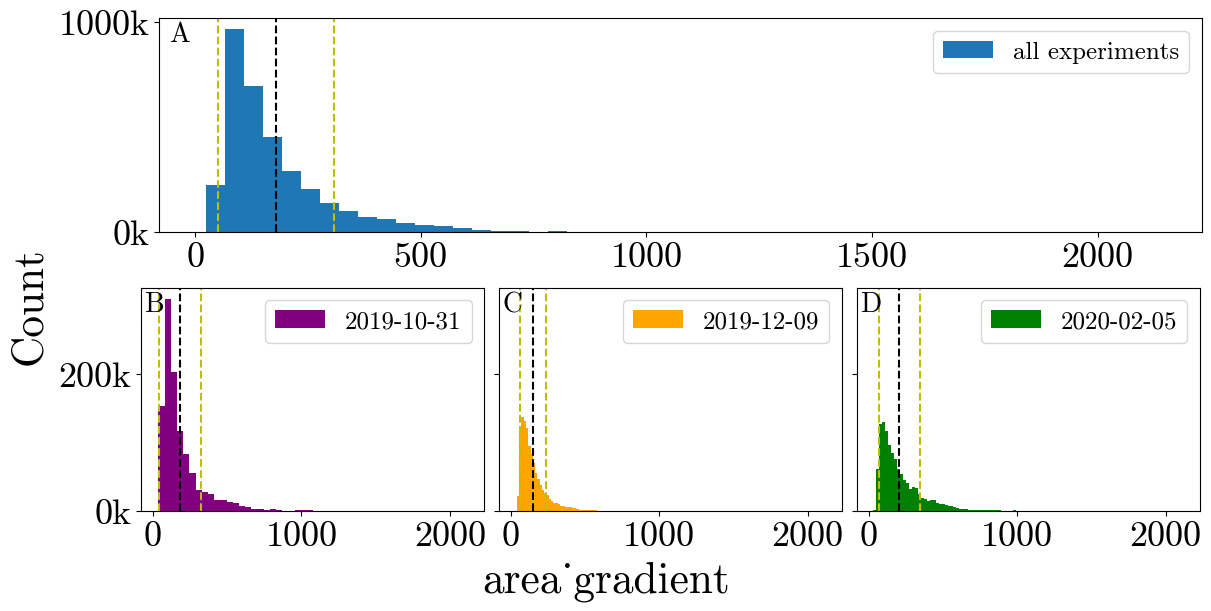

In [11]:
fig = plt.figure(layout="constrained", figsize=(12, 6),)
subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

axs0 = subfigs[0].subplots(1,1)

column = 'area_gradient' # 'area_ml'

# ---- Upper plot ----
axs0.hist(fourier_df[column], 50, label=f"all experiments") 
# axs0.hist(fourier_df['area_ml'], 50,label=f"2019-10-31", color='blue', alpha=0.5) 
m = fourier_df[column].mean()
sd = fourier_df[column].std()
axs0.axvline(m, color='k', linestyle='dashed') 
axs0.axvline(m + sd, color='y', linestyle='dashed') 
axs0.axvline(m - sd, color='y', linestyle='dashed') 
axs0.legend(loc='upper right', fontsize=18)
# axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
axs0.yaxis.set_major_formatter(formatter)
# ---- Bottom three ----
axs1 = subfigs[1].subplots(1, 3, sharex=True, sharey=True)
for ax in axs1:
    formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
    ax.yaxis.set_major_formatter(formatter)

# Lower left
ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
axs1[0].hist(ex1_df[column], 50,label=f"2019-10-31", color='purple') 
m = ex1_df[column].mean()
sd = ex1_df[column].std()
axs1[0].axvline(m, color='k', linestyle='dashed') 
axs1[0].axvline(m + sd, color='y', linestyle='dashed') 
axs1[0].axvline(m - sd, color='y', linestyle='dashed') 
axs1[0].legend(loc='upper right', fontsize=18)

# Lower middle
ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']
axs1[1].hist(ex3_df[column], 50, label=f"2019-12-09", color='orange') 
axs1[1].legend(loc='upper right', fontsize=18)
m = ex3_df[column].mean()
sd = ex3_df[column].std()
axs1[1].axvline(m, color='k', linestyle='dashed') 
axs1[1].axvline(m + sd, color='y', linestyle='dashed') 
axs1[1].axvline(m - sd, color='y', linestyle='dashed') 

# Lower right
ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
axs1[2].hist(ex2_df[column], 50,label=f"2020-02-05", color='green') 
axs1[2].legend(loc='upper right', fontsize=18)
m = ex2_df[column].mean()
sd = ex2_df[column].std()
axs1[2].axvline(m, color='k', linestyle='dashed') 
axs1[2].axvline(m + sd, color='y', linestyle='dashed') 
axs1[2].axvline(m - sd, color='y', linestyle='dashed') 

axs0.text(.02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes)
axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes)
axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes)
axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes)

# # Set common labels
fig.supxlabel(column)
fig.supylabel('Count')
fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/granule_size_dist.svg")   

# Predicted Area comparison 

C:\Users\Endre\AppData\Local\Temp\ipykernel_6560\173562299.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Endre\AppData\Local\Temp\ipykernel_6560\173562299.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


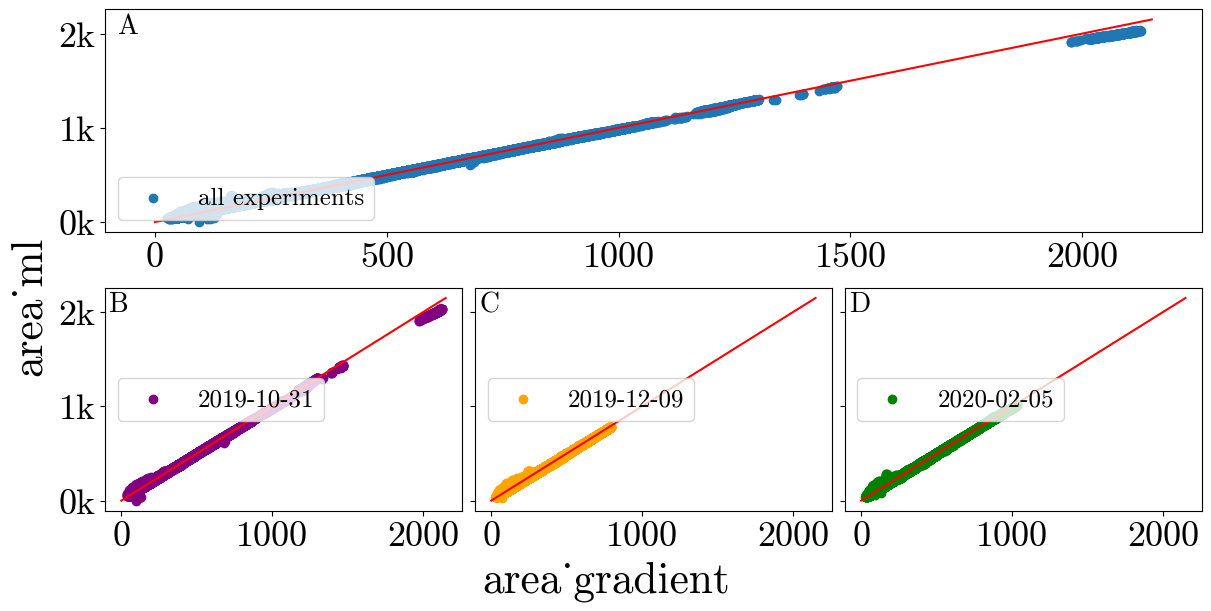

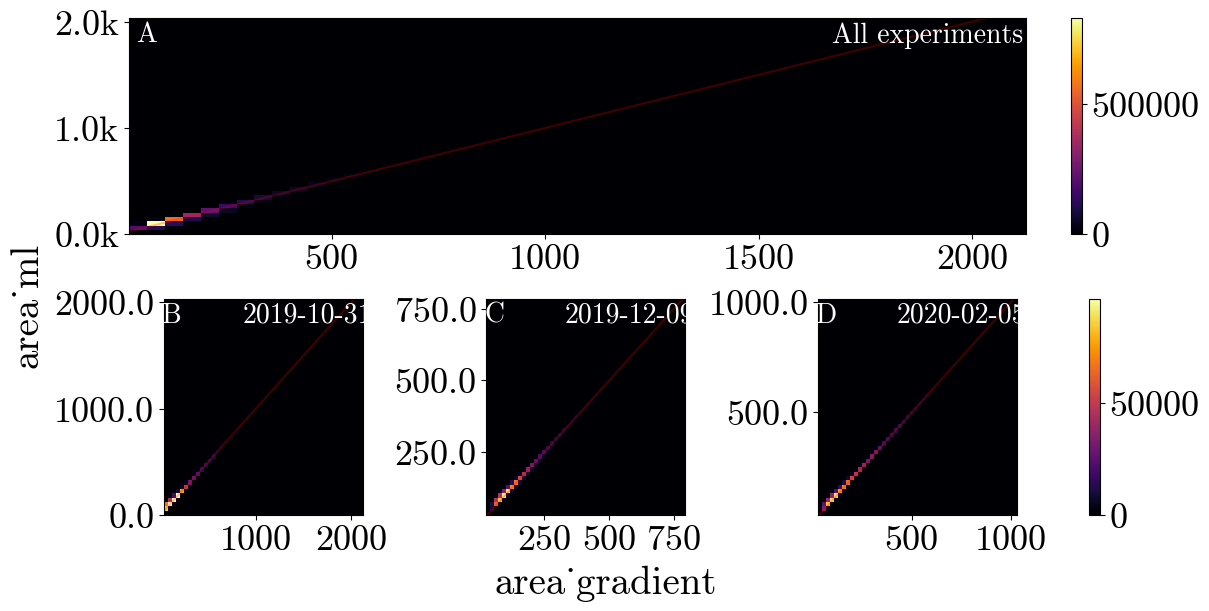

In [23]:
plot_scatter_and_heatmap(colum_x='area_gradient', colum_y='area_ml', x_axis_title="area_gradient", y_axis_title="area_ml", filename="", thousends=True, line=True)

In [10]:
# fig, axd = plt.subplot_mosaic([['upper', 'upper', 'upper'],
#                                ['lower left', 'lower middle', 'lower right']],
#                               figsize=(12,8), layout="constrained", sharex=False, sharey=True)
# # fig.suptitle('Predicted Area Comparison')

# # Upper
# axd['upper'].scatter(fourier_df['area_gradient'], fourier_df['area_ml'], rasterized=True, label=f"All experiments", ) #label=f"Granule Area",, 'o', ls='-', ms=4)
# axd['upper'].plot([0,2150], [0, 2150], label=f"Perfect area match", c='red')
# axd['upper'].legend(loc='lower right', fontsize=18)
# # Lower left
# ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
# axd['lower left'].scatter(ex1_df['area_gradient'], ex1_df['area_ml'], rasterized=True, label=f"2019-10-31", c='purple') #, 'o', ls='-', ms=4)
# axd['lower left'].plot([0,2100], [0, 2100], label=f"", c='red', alpha=0.7)
# axd['lower left'].legend(loc='lower right', fontsize=18)

# # Lower middle
# ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']
# axd['lower middle'].scatter(ex3_df['area_gradient'], ex3_df['area_ml'], rasterized=True, label=f"2019-12-09", c='orange') #, 'o', ls='-', ms=4)
# axd['lower middle'].plot([0,2100], [0, 2100], c='red', alpha=0.7)
# axd['lower middle'].legend(loc='lower right', fontsize=18)
# # axd['lower left'].legend(loc='lower right')

# # Lower right
# ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
# axd['lower right'].scatter(ex2_df['area_gradient'], ex2_df['area_ml'], rasterized=True, label=f"2020-02-05", c='green') #, 'o', ls='-', ms=4)
# axd['lower right'].plot([0,2100], [0, 2100], label=f"", c='red', alpha=0.7)
# axd['lower right'].legend(loc='lower right', fontsize=18)

# axd['upper'].text(.02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axd['upper'].transAxes)
# axd['lower left'].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axd['lower left'].transAxes)
# axd['lower middle'].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axd['lower middle'].transAxes)
# axd['lower right'].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axd['lower right'].transAxes)

# # # Set common labels
# fig.supxlabel('ML Area')
# fig.supylabel('Gradient Area')
# fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/ML_Gradient_comparison.svg", dpi=300)   


In [11]:
fourier_df[fourier_df['area_gradient'] > 1800].shape[0]

566

## ML Area Error % on gradient predicted area

C:\Users\Endre\AppData\Local\Temp\ipykernel_6560\173562299.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Endre\AppData\Local\Temp\ipykernel_6560\173562299.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


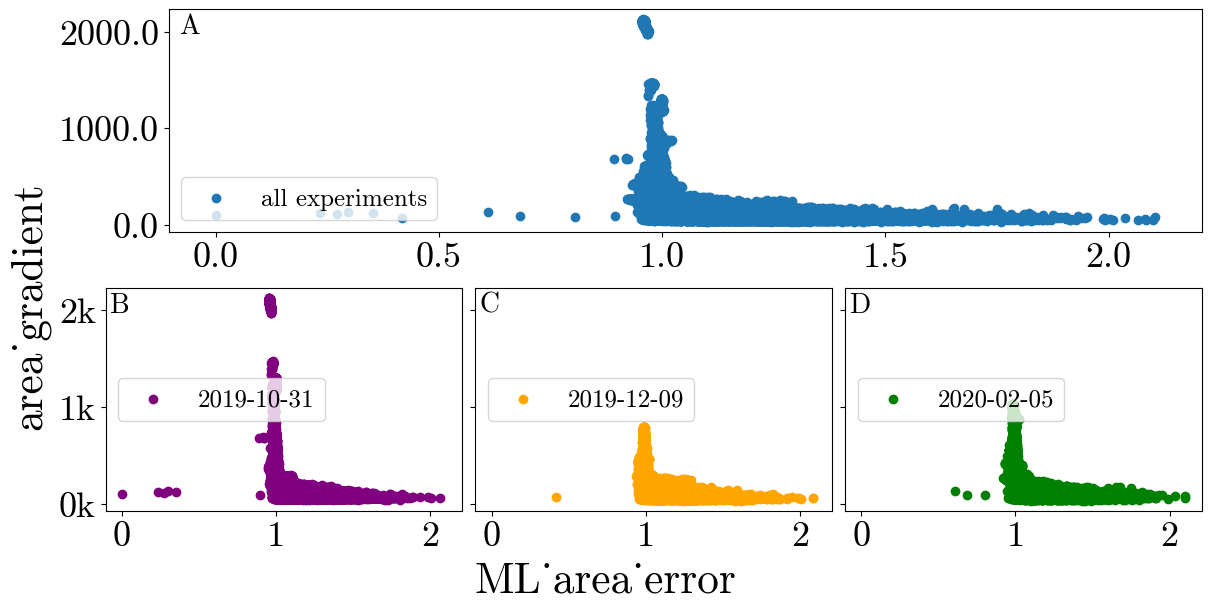

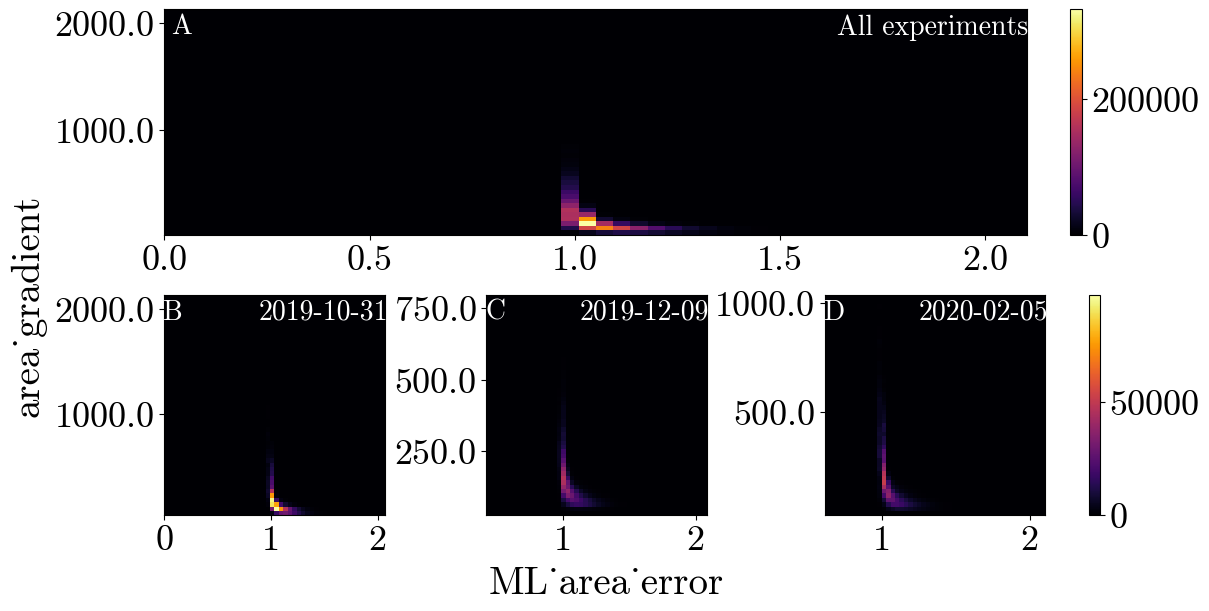

In [34]:
plot_scatter_and_heatmap(colum_x='ML_area_error', colum_y='area_gradient', x_axis_title="ML_area_error", y_axis_title="area_gradient", filename="", thousends=False)

In [13]:
# fig = plt.figure(layout="constrained", figsize=(12, 6),)
# subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

# axs0 = subfigs[0].subplots(1,1)

# # ---- Upper plot ----
# axs0.scatter(fourier_df['area_ml'] / fourier_df['area_gradient'], fourier_df['area_gradient'], rasterized=True, label=f"all experiments") 
# axs0.legend(loc='upper right', fontsize=18)
# # axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
# formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
# axs0.yaxis.set_major_formatter(formatter)
# # ---- Bottom three ----
# axs1 = subfigs[1].subplots(1, 3, sharex=True, sharey=True)
# for ax in axs1:
#     formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
#     ax.yaxis.set_major_formatter(formatter)

# # Lower left
# ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
# axs1[0].scatter(ex1_df['area_ml'] / ex1_df['area_gradient'], ex1_df['area_gradient'], rasterized=True, label=f"2019-10-31", color='purple') 
# axs1[0].legend(loc='upper right', fontsize=18)

# # Lower middle
# ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']
# axs1[1].scatter(ex3_df['area_ml'] / ex3_df['area_gradient'], ex3_df['area_gradient'], rasterized=True, label=f"2019-12-09", color='orange') 
# axs1[1].legend(loc='upper right', fontsize=18)

# # Lower right
# ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
# axs1[2].scatter(ex2_df['area_ml'] / ex2_df['area_gradient'], ex2_df['area_gradient'], rasterized=True, label=f"2020-02-05", color='green') 
# axs1[2].legend(loc='upper right', fontsize=18)

# axs0.text(.02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes)
# axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes)
# axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes)
# axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes)

# # # Set common labels
# fig.supxlabel('ML Area Error %', fontsize=28)
# fig.supylabel('Predicted Area (Gradient)', fontsize=28)
# fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/Granule_Area_error.svg")   

# Heatmap version

In [14]:
# fig = plt.figure(layout="constrained", figsize=(12, 6),)
# subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

# axs0 = subfigs[0].subplots(1,1)

# # ---- Upper plot ----
# # H, xedges, yedges = np.histogram2d(fourier_df['area_ml'] / fourier_df['area_gradient'], fourier_df['area_gradient'], bins=25)
# # im0 = axs0.imshow(H.T, interpolation='nearest', origin='lower', cmap=plt.colormaps["inferno"])
# # fig.colorbar(im0, ax=axs0)
# # axs0.legend(loc='upper right', fontsize=18)
# # axs0.set_aspect('auto')

# im0 = axs0.hist2d(fourier_df['ML_area_error'], fourier_df['area_gradient'], label=f"ALL", bins=50, cmap=plt.colormaps["inferno"]) 
# fig.colorbar(im0[3], ax=axs0)

# # axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
# formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.1fk' % (x * 1e-3))
# axs0.yaxis.set_major_formatter(formatter)
# # ---- Bottom three ----
# axs1 = subfigs[1].subplots(1, 3,)# sharey=True)
# for ax in axs1:
#     formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.1fk' % (x * 1e-3))
#     ax.yaxis.set_major_formatter(formatter)

# ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
# ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
# ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']

# h1, _,_,_ = plt.hist2d(ex1_df['ML_area_error'], ex1_df['area_gradient'], bins=50)
# h2, _,_,_ = plt.hist2d(ex2_df['ML_area_error'], ex2_df['area_gradient'], bins=50)
# h3, _,_,_ = plt.hist2d(ex3_df['ML_area_error'], ex3_df['area_gradient'], bins=50)

# vmax = np.max((h1,h2,h3))

# # Lower left
# im00 = axs1[0].hist2d(ex1_df['ML_area_error'], ex1_df['area_gradient'], label=f"2019-10-31", bins=50, cmap=plt.colormaps["inferno"], vmax=vmax) 
# # fig.colorbar(im00[3], ax=axs1)
# # axs1[0].legend(loc='upper right', fontsize=18)
# # axs1[0].set_aspect('auto')

# # # Lower middle
# im11 = axs1[1].hist2d(ex3_df['ML_area_error'], ex3_df['area_gradient'], label=f"2019-12-09", bins=50, cmap=plt.colormaps["inferno"], vmax=vmax) 
# # axs1[1].legend(loc='upper right', fontsize=18)
# # axs1.set_aspect('auto')

# # # Lower right
# axs1[2].hist2d(ex2_df['ML_area_error'], ex2_df['area_gradient'], label=f"2020-02-05", bins=50, cmap=plt.colormaps["inferno"], vmax=vmax) 
# # axs1[2].legend(loc='upper right', fontsize=18)
# # axs1[2].set_aspect('auto')

# fig.colorbar(im00[3], ax=axs1) # Colorbar is the same for all three bottom plots

# axs0.text(   .02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes   , color='white')
# axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes, color='white')
# axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes, color='white')
# axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes, color='white')

# axs0.text(   .890, .920, 'All experiments', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes,    color='white')
# axs1[0].text(.720, .925, '2019-10-31', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes, color='white')
# axs1[1].text(.720, .925, '2019-12-09', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes, color='white')
# axs1[2].text(.720, .925, '2020-02-05', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes, color='white')

# # # Set common labels
# fig.supxlabel('ML Area Error %', fontsize=28)
# fig.supylabel('Predicted Area (Gradient)', fontsize=28)
# # fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/Granule_Area_error.svg")   

# # fig.colorbar(h[3], ax=axs1.ravel().tolist())

## ML Area Error distribution 

Mean: 1.057 Std: 0.081


Text(0.02, 0.5, 'Count')

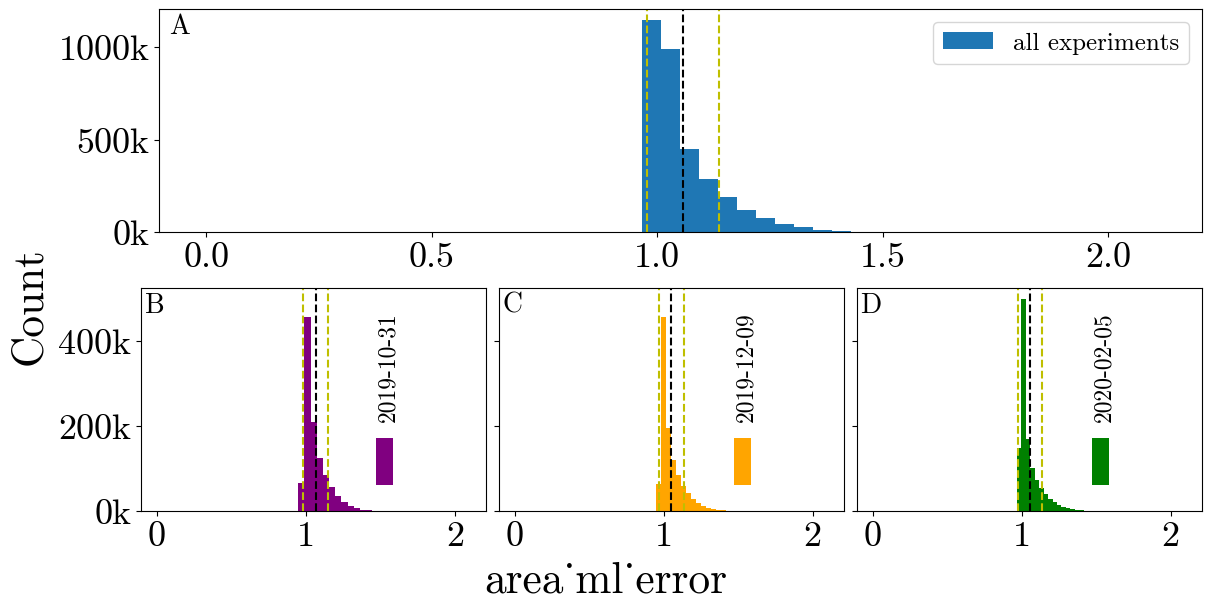

In [27]:
fig = plt.figure(layout="constrained", figsize=(12, 6),)
subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

axs0 = subfigs[0].subplots(1,1)

fourier_df['area_ml_error'] = fourier_df['area_ml'] / fourier_df['area_gradient']
column = 'area_ml_error' #'area_gradient'

# ---- Upper plot ----
axs0.hist(fourier_df[column], 50, label=f"all experiments") 
m = fourier_df[column].mean()
sd = fourier_df[column].std()
print(f"Mean: {np.round(m,3)} Std: {np.round(sd,3)}")
axs0.axvline(m, color='k', linestyle='dashed') 
axs0.axvline(m + sd, color='y', linestyle='dashed') 
axs0.axvline(m - sd, color='y', linestyle='dashed') 
axs0.legend(loc='upper right', fontsize=18)
# axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
axs0.yaxis.set_major_formatter(formatter)
# ---- Bottom three ----
axs1 = subfigs[1].subplots(1, 3, sharex=True, sharey=True)
for ax in axs1:
    formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
    ax.yaxis.set_major_formatter(formatter)

# Lower left
ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
axs1[0].hist(ex1_df[column], 50,label=f"2019-10-31", color='purple') 
m = ex1_df[column].mean()
sd = ex1_df[column].std()
axs1[0].axvline(m, color='k', linestyle='dashed') 
axs1[0].axvline(m + sd, color='y', linestyle='dashed') 
axs1[0].axvline(m - sd, color='y', linestyle='dashed') 
# axs1[0].legend(loc='upper right', fontsize=18)
LegendVertical(axs1[0], 90, XPad=-70, YPad=30, fontsize=17, loc='lower right')

# Lower middle
ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']
axs1[1].hist(ex3_df[column], 50, label=f"2019-12-09", color='orange') 
# axs1[1].legend(loc='upper right', fontsize=18)
LegendVertical(axs1[1], 90, XPad=-70, YPad=30, fontsize=17, loc='lower right')
m = ex3_df[column].mean()
sd = ex3_df[column].std()
axs1[1].axvline(m, color='k', linestyle='dashed') 
axs1[1].axvline(m + sd, color='y', linestyle='dashed') 
axs1[1].axvline(m - sd, color='y', linestyle='dashed') 

# Lower right
ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
axs1[2].hist(ex2_df[column], 50,label=f"2020-02-05", color='green') 
# axs1[2].legend(loc='upper right', fontsize=10,)
LegendVertical(axs1[2], 90, XPad=-70, YPad=30, fontsize=17, loc='lower right')
m = ex2_df[column].mean()
sd = ex2_df[column].std()
axs1[2].axvline(m, color='k', linestyle='dashed') 
axs1[2].axvline(m + sd, color='y', linestyle='dashed') 
axs1[2].axvline(m - sd, color='y', linestyle='dashed') 

axs0.text(.02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes)
axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes)
axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes)
axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes)

# # Set common labels
fig.supxlabel(column)
fig.supylabel('Count')
# fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/granule_size_dist.svg")   

# Add Mean radius

## ML Area Error % on mean intensity

C:\Users\Endre\AppData\Local\Temp\ipykernel_6560\173562299.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Endre\AppData\Local\Temp\ipykernel_6560\173562299.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


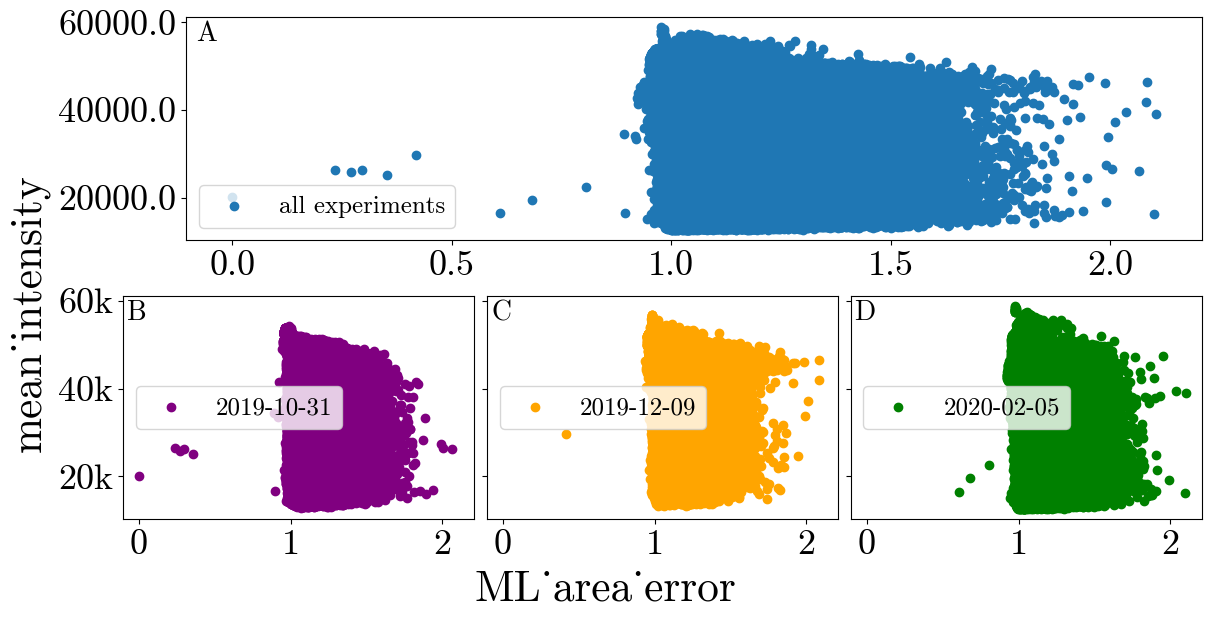

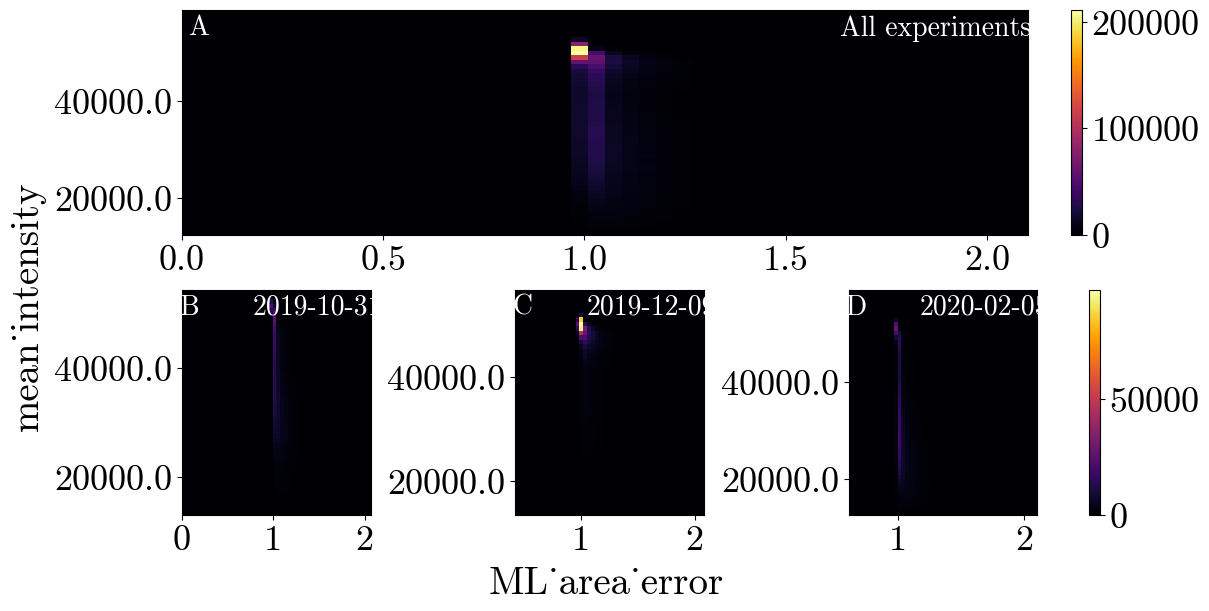

In [33]:
plot_scatter_and_heatmap(colum_x='ML_area_error', colum_y='mean_intensity', x_axis_title="ML_area_error", y_axis_title="mean_intensity", filename="", thousends=False)

In [35]:
# fig = plt.figure(layout="constrained", figsize=(12, 6),)
# subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

# axs0 = subfigs[0].subplots(1,1)

# # ---- Upper plot ----
# axs0.scatter(fourier_df['ML_area_error'], fourier_df['mean_intensity'], label=f"all experiments") 
# axs0.legend(loc='lower left', fontsize=18)
# # axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
# formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
# axs0.yaxis.set_major_formatter(formatter)
# # ---- Bottom three ----
# axs1 = subfigs[1].subplots(1, 3, sharex=True, sharey=True)
# for ax in axs1:
#     formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
#     ax.yaxis.set_major_formatter(formatter)

# # Lower left
# ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
# axs1[0].scatter(ex1_df['ML_area_error'], ex1_df['mean_intensity'], rasterized=True, label=f"2019-10-31", color='purple') 
# axs1[0].legend(loc='center left', fontsize=18)

# # Lower middle
# ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']
# axs1[1].scatter(ex3_df['ML_area_error'], ex3_df['mean_intensity'], rasterized=True, label=f"2019-12-09", color='orange') 
# axs1[1].legend(loc='center left', fontsize=18)

# # Lower right
# ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
# axs1[2].scatter(ex2_df['ML_area_error'], ex2_df['mean_intensity'], rasterized=True, label=f"2020-02-05", color='green') 
# axs1[2].legend(loc='center left', fontsize=18)

# axs0.text(.02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes)
# axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes)
# axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes)
# axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes)

# # # Set common labels
# fig.supxlabel('ML Area Error %')
# fig.supylabel('Mean Intensity')
# fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/Granule_Intensity_ML_Area_Error.svg")   

# IoU

In [29]:
mean_IoU = fourier_df['IoU'].mean()
print("Mean IoU", mean_IoU)
IoU_std = fourier_df['IoU'].std()
print("Std IoU", IoU_std)

Mean IoU 0.8357039092778565
Std IoU 0.12276330652001279


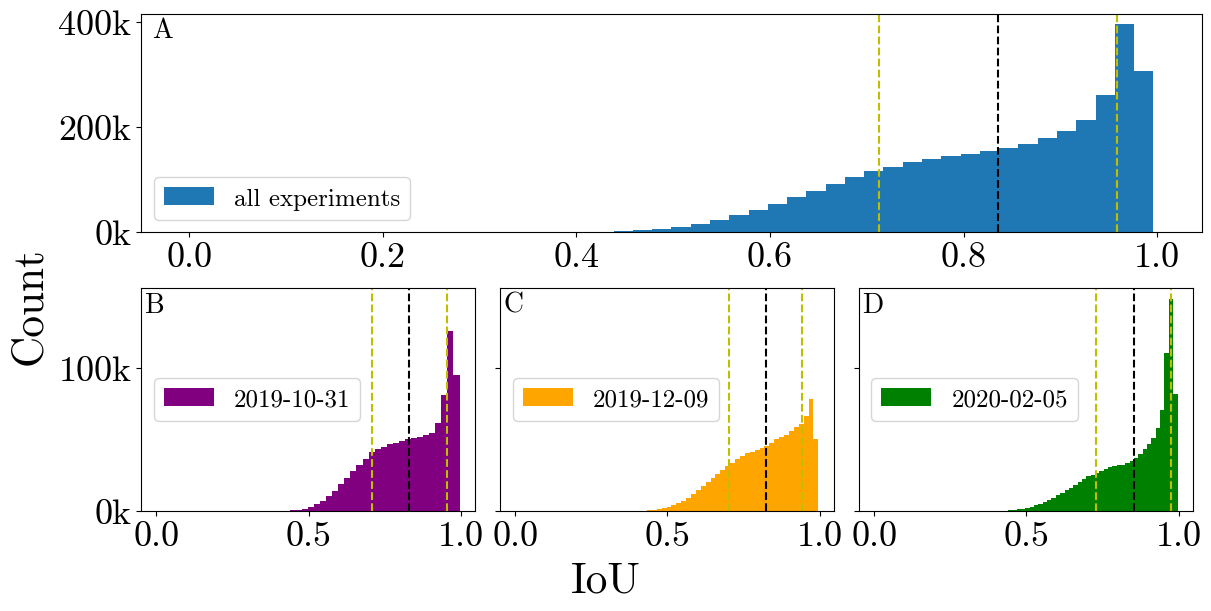

In [40]:
fig = plt.figure(layout="constrained", figsize=(12, 6),)
subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

axs0 = subfigs[0].subplots(1,1)

# ---- Upper plot ----
axs0.hist(fourier_df['IoU'], 50, label=f"all experiments") 
m = fourier_df['IoU'].mean()
sd = fourier_df['IoU'].std()
axs0.axvline(m, color='k', linestyle='dashed') 
axs0.axvline(m + sd, color='y', linestyle='dashed') 
axs0.axvline(m - sd, color='y', linestyle='dashed') 
axs0.legend(loc='lower left', fontsize=18)
# axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
axs0.yaxis.set_major_formatter(formatter)
# ---- Bottom three ----
axs1 = subfigs[1].subplots(1, 3, sharex=True, sharey=True)
for ax in axs1:
    formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
    ax.yaxis.set_major_formatter(formatter)

# Lower left
ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
axs1[0].hist(ex1_df['IoU'], 50,label=f"2019-10-31", color='purple') 
m = ex1_df['IoU'].mean()
sd = ex1_df['IoU'].std()
axs1[0].axvline(m, color='k', linestyle='dashed') 
axs1[0].axvline(m + sd, color='y', linestyle='dashed') 
axs1[0].axvline(m - sd, color='y', linestyle='dashed') 
axs1[0].legend(loc='center left', fontsize=18)

# Lower middle
ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']
axs1[1].hist(ex3_df['IoU'], 50, label=f"2019-12-09", color='orange') 
axs1[1].legend(loc='center left', fontsize=18)
m = ex3_df['IoU'].mean()
sd = ex3_df['IoU'].std()
axs1[1].axvline(m, color='k', linestyle='dashed') 
axs1[1].axvline(m + sd, color='y', linestyle='dashed') 
axs1[1].axvline(m - sd, color='y', linestyle='dashed') 

# Lower right
ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
axs1[2].hist(ex2_df['IoU'], 50,label=f"2020-02-05", color='green') 
axs1[2].legend(loc='center left', fontsize=18)
m = ex2_df['IoU'].mean()
sd = ex2_df['IoU'].std()
axs1[2].axvline(m, color='k', linestyle='dashed') 
axs1[2].axvline(m + sd, color='y', linestyle='dashed') 
axs1[2].axvline(m - sd, color='y', linestyle='dashed') 

axs0.text(.02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes)
axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes)
axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes)
axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes)

# # Set common labels
fig.supxlabel('IoU')
fig.supylabel('Count')
fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/Granule_IoU_dist.svg")   

C:\Users\Endre\AppData\Local\Temp\ipykernel_6560\173562299.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Endre\AppData\Local\Temp\ipykernel_6560\173562299.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


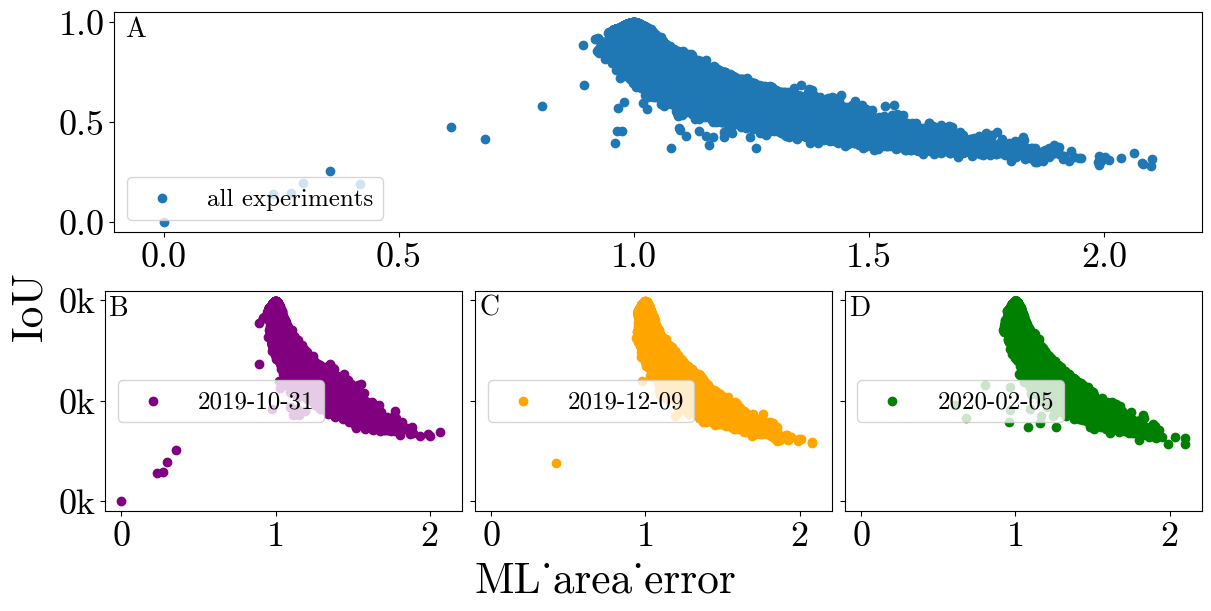

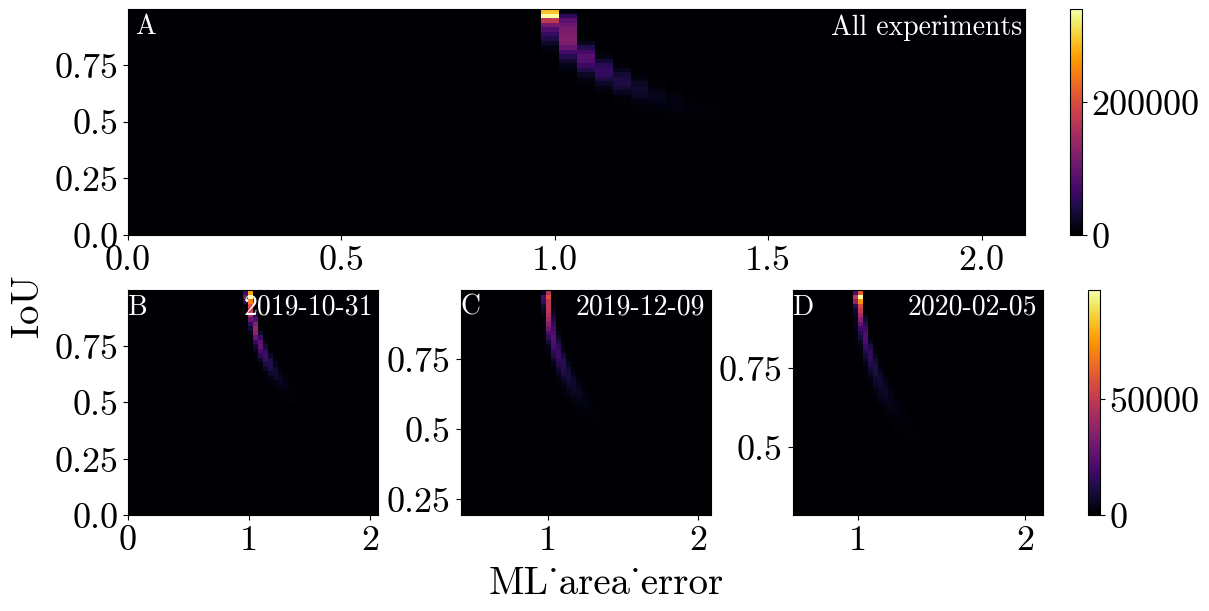

In [39]:
plot_scatter_and_heatmap(colum_x='ML_area_error', colum_y='IoU', x_axis_title="ML_area_error", y_axis_title="IoU", filename="", thousends=False)

contrast agains surf-tention, etc. 

Filter out small granules: Run again to get new data, say that model works well on large granules.

In [31]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), layout='constrained')
# # --- Hist ---
# ax.hist(fourier_df["mean_intensity"], bins=25, linewidth=0.5, edgecolor="white")
# ax.set_ylabel('Count')
# ax.set_xlabel('Mean Intensity')
# # fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/Granule_IoU_dist.svg")   

In [ ]:
fig = plt.figure(layout="constrained", figsize=(12, 6),)
subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

axs0 = subfigs[0].subplots(1,1)

# ---- Upper plot ----
axs0.scatter(fourier_df['IoU'], fourier_df['mean_intensity'], rasterized=True, label=f"all experiments") 
axs0.legend(loc='lower left', fontsize=18)
# axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
axs0.yaxis.set_major_formatter(formatter)
# ---- Bottom three ----
axs1 = subfigs[1].subplots(1, 3, sharex=True, sharey=True)
for ax in axs1:
    formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
    ax.yaxis.set_major_formatter(formatter)

# Lower left
ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
axs1[0].scatter(ex1_df['IoU'], ex1_df['mean_intensity'], rasterized=True, label=f"2019-10-31", color='purple') 
axs1[0].legend(loc='center left', fontsize=18)

# Lower right
ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']
axs1[1].scatter(ex3_df['IoU'], ex3_df['mean_intensity'], rasterized=True,label=f"2019-12-09", color='orange') 
axs1[1].legend(loc='center left', fontsize=18)

# Lower middle
ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
axs1[2].scatter(ex2_df['IoU'], ex2_df['mean_intensity'], rasterized=True, label=f"2020-02-05", color='green') 
axs1[2].legend(loc='center left', fontsize=18)



axs0.text(.02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes)
axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes)
axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes)
axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes)

# # Set common labels
fig.supxlabel('IoU')
fig.supylabel('Mean Intensity')
# fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/Granule_IoU_dist.svg")   

In [ ]:
# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), layout='constrained')
# ax1.scatter(fourier_df['IoU'], fourier_df['mean_intensity'], label=f"Granule Area", ) #, 'o', ls='-', ms=4)
# ax1.set_ylabel('Mean Intensity')
# ax1.set_xlabel('IoU')
# ax1.legend(loc='lower right')
# # fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/ML_Gradient_Area_comparison.svg", )#height=1000, width=1000)

Text(0.5, 0.01, 'Mean radius')

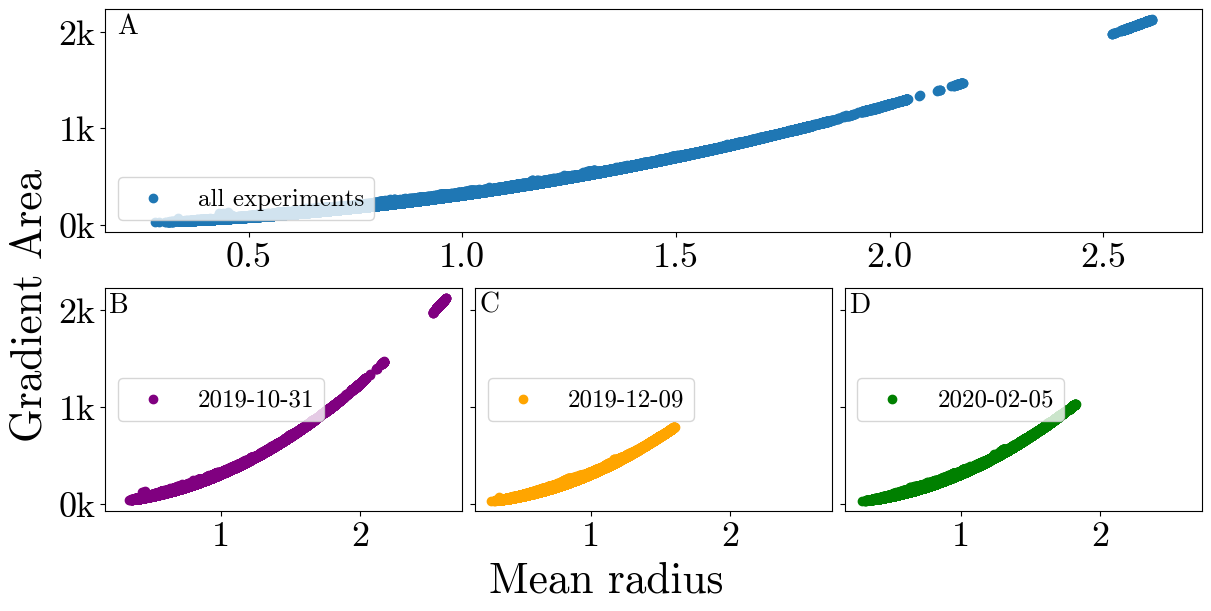

In [ ]:
fig = plt.figure(layout="constrained", figsize=(12, 6),)
subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

axs0 = subfigs[0].subplots(1,1)

# ---- Upper plot ----
axs0.scatter(fourier_df['mean_radius'], fourier_df['area_gradient'], rasterized=True, label=f"all experiments") 
axs0.legend(loc='lower left', fontsize=18)
# axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
axs0.yaxis.set_major_formatter(formatter)
# ---- Bottom three ----
axs1 = subfigs[1].subplots(1, 3, sharex=True, sharey=True)
for ax in axs1:
    formatter = mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3))
    ax.yaxis.set_major_formatter(formatter)

# Lower left
ex1_df = fourier_df[fourier_df['file_name'] == '2019-10-31']
axs1[0].scatter(ex1_df['mean_radius'], ex1_df['area_gradient'], rasterized=True, label=f"2019-10-31", color='purple') 
axs1[0].legend(loc='center left', fontsize=18)

# Lower right
ex3_df = fourier_df[fourier_df['file_name'] == '2019-12-09']
axs1[1].scatter(ex3_df['mean_radius'], ex3_df['area_gradient'], rasterized=True,label=f"2019-12-09", color='orange') 
axs1[1].legend(loc='center left', fontsize=18)

# Lower middle
ex2_df = fourier_df[fourier_df['file_name'] == '2020-02-05']
axs1[2].scatter(ex2_df['mean_radius'], ex2_df['area_gradient'], rasterized=True, label=f"2020-02-05", color='green') 
axs1[2].legend(loc='center left', fontsize=18)



axs0.text(.02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes)
axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes)
axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes)
axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes)

# # Set common labels
fig.supylabel('Gradient Area')
fig.supxlabel('Mean radius')
# fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/Granule_mean_radius_dist.svg")   

# Matplotlib Legend Rotation Code

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def LegendVertical(Ax, Rotation=90, XPad=0, YPad=0, **LegendArgs):
    if Rotation not in (90,270):
        raise NotImplementedError('Rotation must be 90 or 270.')

    # Extra spacing between labels is needed to fit the rotated labels;
    # and since the frame will not adjust to the rotated labels, it is
    # disabled by default
    DefaultLoc = 'center left' if Rotation==90 else 'center right'
    ArgsDefaults = dict(loc=DefaultLoc, labelspacing=4, frameon=False)
    Args = {**ArgsDefaults, **LegendArgs}

    Handles, Labels = Ax.get_legend_handles_labels()
    if Rotation==90:
        # Reverse entries
        Handles, Labels = (reversed(_) for _ in (Handles, Labels))
    AxLeg = Ax.legend(Handles, Labels, **Args)

    LegTexts = AxLeg.get_texts()
    LegHandles = AxLeg.legend_handles

    for L,Leg in enumerate(LegHandles):
        if type(Leg) == matplotlib.patches.Rectangle:
            BBounds = np.ravel(Leg.get_bbox())
            BBounds[2:] = BBounds[2:][::-1]
            Leg.set_bounds(BBounds)

            LegPos = (
                # Ideally,
                #    `(BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad`
                # should be at the horizontal center of the legend patch,
                # but for some reason it is not. Therefore the user will
                # need to specify some padding.
                (BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad + XPad,

                # Similarly, `(BBounds[1]+BBounds[3])` should be at the vertical
                # top of the legend patch, but it is not.
                (BBounds[1]+BBounds[3])+YPad
            )

        elif type(Leg) == matplotlib.lines.Line2D:
            LegXY = Leg.get_xydata()[:,::-1]
            Leg.set_data(*(LegXY[:,_] for _ in (0,1)))

            LegPos = (
                LegXY[0,0] - AxLeg.handletextpad + XPad,
                max(LegXY[:,1]) + YPad
            )

        elif type(Leg) == matplotlib.collections.PathCollection:
            LegPos = (
                Leg.get_offsets()[0][0] + XPad,
                Leg.get_offsets()[0][1] + YPad,
            )
        else:
            raise NotImplementedError('Legends should contain Rectangle, Line2D or PathCollection.')

        PText = LegTexts[L]
        PText.set_verticalalignment('bottom')
        PText.set_rotation(Rotation)
        PText.set_x(LegPos[0])
        PText.set_y(LegPos[1])

    return(None)

# FINAL PLOTS

In [57]:
fourier_df[:4]
fourier_df.columns

Index(['granule_ids', 'frames', 'area_gradient', 'area_ml', 'IoU',
       'gradient_mean_intensity', 'gradient_mean_radius',
       'gradient_major_axis', 'gradient_minor_axis', 'gradient_eccentricity',
       'ml_mean_intensity', 'ml_mean_radius', 'ml_major_axis', 'ml_minor_axis',
       'ml_eccentricity', 'granules_is_common', 'ml_exlusive',
       'gradient_exclusive', 'Gradient_valid', 'ML_valid',
       'Granules_in_common_count', 'Gradient_exclusive_count',
       'ML_exlusive_count', 'file', 'file_name', 'ML_area_error'],
      dtype='object')

In [24]:
# fourier_df_cropped = fourier_df[fourier_df['area_gradient'] < 1000]

# # ------------------------------ HEATMAP ------------------------------
# fig = plt.figure(layout="constrained", figsize=(12, 6),)
# subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

# axs0 = subfigs[0].subplots(1,2)

# fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['ML_area_error'] > 0.85) & (fourier_df_cropped['ML_area_error'] < 1.6)]
# axs0[0].hist(fourier_df_cropped_area['ML_area_error'], 50, label=f"") 
# axs0[0].set(xlabel="ML Area Error", ylabel="Count")
# m = fourier_df['ML_area_error'].mean()
# sd = fourier_df['ML_area_error'].std()
# print(f"Mean: {np.round(m,3)} Std: {np.round(sd,3)}")
# axs0[0].axvline(m, color='k', linestyle='dashed') 
# axs0[0].axvline(m + sd, color='y', linestyle='dashed') 
# axs0[0].axvline(m - sd, color='y', linestyle='dashed') 
# axs0[0].legend(loc='upper right', fontsize=18)

# axs0[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))

# # im0 = axs0.hist2d(fourier_df_cropped['ML_area_error'], fourier_df_cropped['area_gradient'], label=f"ALL", bins=50, cmap=plt.colormaps["inferno"]) 
# fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['ML_area_error'] > 0.85) & (fourier_df_cropped['ML_area_error'] < 1.3)]
# im0 = axs0[1].hist2d(fourier_df_cropped_area['ML_area_error'], fourier_df_cropped_area['area_gradient'], label=f"ALL", bins=25, cmap=plt.colormaps["inferno"]) 
# axs0[1].set(xlabel="ML Area Error",ylabel="IoU")
# fig.colorbar(im0[3], ax=axs0)
# # axs0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) # Used for setting , as seperator
# formatter = mpl.ticker.FuncFormatter(lambda x, pos: x)#'%1.1fk' % (x * 1e-3))
# axs0[1].yaxis.set_major_formatter(formatter)


# # ---- Bottom three ----
# axs1 = subfigs[1].subplots(1, 3,)# sharey=True)
# # for ax in axs1:
# #     formatter = mpl.ticker.FuncFormatter(lambda x, pos: x)#'%1.1fk' % (x * 1e-3))
# #     ax.yaxis.set_major_formatter(formatter)

# # Lower left
# im00 = axs1[0].hist2d(fourier_df_cropped['area_gradient'], fourier_df_cropped['area_ml'], label=f"2019-10-31", bins=50, cmap=plt.colormaps["inferno"]) 
# cbar = fig.colorbar(im00[3], ax=axs1[0])
# cbar.set_ticklabels([f"{int(a/1000)}k" for a in cbar.get_ticks()])
# axs1[0].set(xlabel="Gradient Area", ylabel="ML Area")
# # axs1[0].legend(loc='upper right', fontsize=18)
# # axs1[0].set_aspect('auto')

# # # Lower middle
# im00 = axs1[1].scatter(fourier_df_cropped['area_gradient'], fourier_df_cropped['area_ml'], label=f"2019-10-31") 
# axs1[1].set(xlabel="Gradient Area",ylabel="ML Area")
# axs1[1].plot([0,1000], [0, 1000], label=f"", c='red', alpha=1)
# # im11 = axs1[1].hist2d(ex3_df[colum_x], ex3_df[colum_y], label=f"2019-12-09", bins=50, cmap=plt.colormaps["inferno"], vmax=vmax) 
# # axs1[1].legend(loc='upper right', fontsize=18)
# # axs1.set_aspect('auto')

# # # Lower right
# fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['ML_area_error'] > 0.9) & (fourier_df_cropped['ML_area_error'] < 1.15)]
# im12 = axs1[2].hist2d(fourier_df_cropped_area['ML_area_error'], fourier_df_cropped_area['gradient_mean_intensity'], label=f"2020-02-05", bins=25, cmap=plt.colormaps["inferno"]) 
# axs1[2].set(xlabel="ML Area Error", ylabel="Mean Intensity")
# cbar = fig.colorbar(im12[3], ax=axs1[2])
# cbar.set_ticklabels([f"{int(a/1000)}k" for a in cbar.get_ticks()])
# axs1[2].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))
# # axs1[2].legend(loc='upper right', fontsize=18)colum_x='ML_area_error', colum_y='mean_intensity'
# # axs1[2].set_aspect('auto')

# # fig.colorbar(im00[3], ax=axs1)

# axs0[1].text(.02, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0[1].transAxes, color='white')
# axs1[0].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes, color='white')
# axs1[1].text(.04, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes, color='white')
# axs1[2].text(.04, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes, color='white')

# # axs0.text(   .890, .920, 'All experiments', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes,    color='white')
# # axs1[0].text(.720, .925, '2019-10-31', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes, color='white')
# # axs1[1].text(.720, .925, '2019-12-09', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes, color='white')
# # axs1[2].text(.720, .925, '2020-02-05', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes, color='white')

# fig.show()

Mean: 179.42 Std: 128.71
Mean: 38272.372 Std: 10595.007


C:\Users\Endre\AppData\Local\Temp\ipykernel_23616\1549691790.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


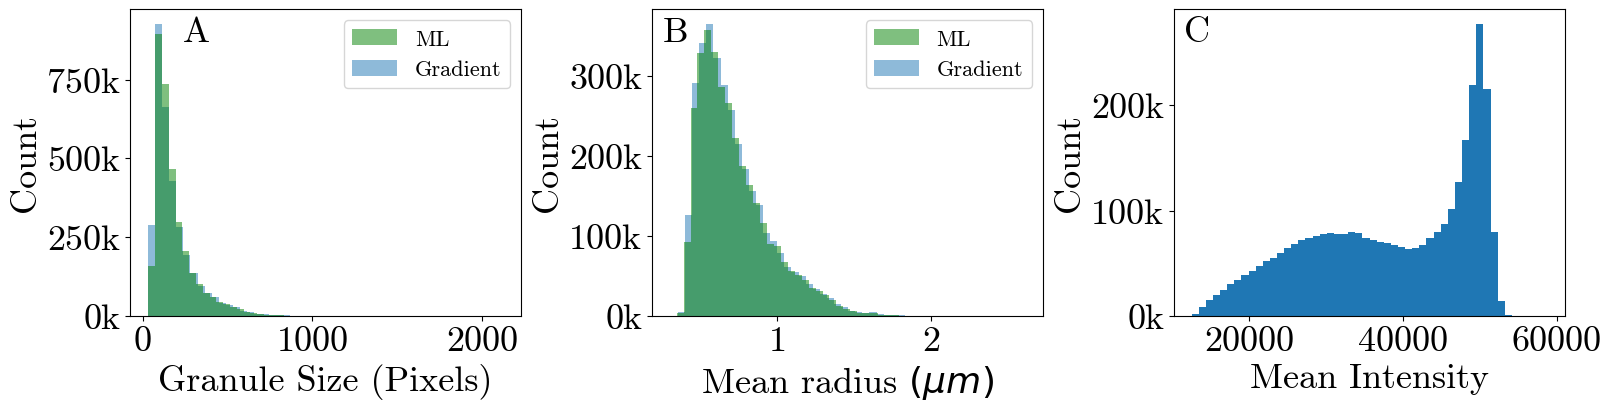

In [83]:
fourier_df_cropped = fourier_df[fourier_df['area_gradient'] > 0]

# ------------------------------ HEATMAP ------------------------------
fig = plt.figure(layout="constrained", figsize=(16, 4),)
subfigs = fig.subfigures(nrows=1, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

axs0 = subfigs.subplots(1,3)

# ------- Top 1 ------- 
fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['area_gradient'] > 0)]
_,_, y_handle = axs0[0].hist(fourier_df_cropped_area['area_gradient'], 50, label=f"Gradient", rasterized=True, alpha=0.5) 
# axs0[0].set(xlabel="Gradient Area", ylabel="Count")
m = fourier_df['area_gradient'].mean()
sd = fourier_df['area_gradient'].std()
print(f"Mean: {np.round(m,3)} Std: {np.round(sd,3)}")
# axs0[0].axvline(m, color='k', linestyle='dashed') 
# axs0[0].axvline(m + sd, color='y', linestyle='dashed') 
# axs0[0].axvline(m - sd, color='y', linestyle='dashed') 
# axs0[0].legend(loc='upper right', fontsize=18)
axs0[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))

_, _, x_handle = axs0[0].hist(fourier_df_cropped_area['area_ml'], 50, label=f"", rasterized=True, color='green', alpha=0.5) 
# axs0[0].set(xlabel="ML Area", ylabel="Count")
axs0[0].set(xlabel="Granule Size (Pixels)", ylabel="Count")
axs0[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))
axs0[0].legend((x_handle, y_handle, (x_handle, y_handle)), ('ML', 'Gradient'), fontsize=16)

# ------- Top 2 ------- 
_,_, y_handle = axs0[1].hist(fourier_df_cropped_area['gradient_mean_radius'], 50, label=f"ML", rasterized=True, alpha=0.5) 
axs0[1].set(xlabel="ML Area", ylabel="Count")
axs0[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))

_, _, x_handle = axs0[1].hist(fourier_df_cropped_area['ml_mean_radius'], 50, label=f"", rasterized=True, color='green', alpha=0.5) 
# axs0[0].set(xlabel="ML Area", ylabel="Count")
axs0[1].set(xlabel="Mean radius $(\mu m)$", ylabel="Count") 
axs0[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))
axs0[1].legend((x_handle, y_handle, (x_handle, y_handle)), ('ML', 'Gradient'), fontsize=16)

# # Lower right
axs0[2].hist(fourier_df_cropped_area['gradient_mean_intensity'], 50, label=f"", rasterized=True, ) 
axs0[2].set(xlabel="Mean Intensity", ylabel="Count")
m = fourier_df['gradient_mean_intensity'].mean()
sd = fourier_df['gradient_mean_intensity'].std()
print(f"Mean: {np.round(m,3)} Std: {np.round(sd,3)}")
# axs0[0].axvline(m, color='k', linestyle='dashed') 
# axs0[0].axvline(m + sd, color='y', linestyle='dashed') 
# axs0[0].axvline(m - sd, color='y', linestyle='dashed') 
# axs1[0].legend(loc='upper right', fontsize=18)
axs0[2].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))

axs0[0].text(.17, .925, 'A', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=axs0[0].transAxes, color='Black')
axs0[1].text(.06, .925, 'B', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=axs0[1].transAxes, color='Black')
axs0[2].text(.06, .925, 'C', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=axs0[2].transAxes, color='Black')


# fig.subplots_adjust(wspace=10, hspace=10)
fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/general_population.svg")   
fig.show()

Mean: 1.057 Std: 0.081


C:\Users\Endre\AppData\Local\Temp\ipykernel_15032\1926757389.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


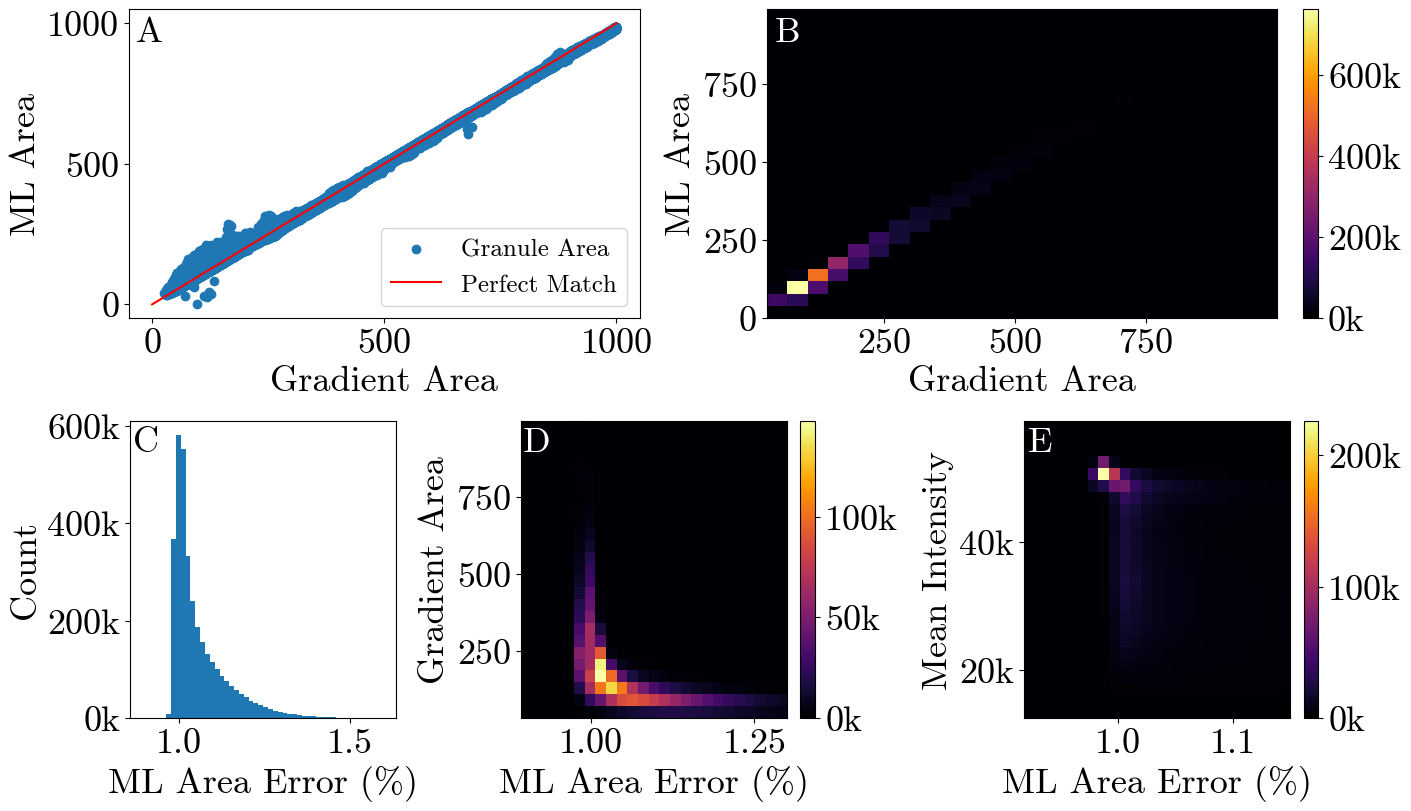

In [7]:
fourier_df_cropped = fourier_df[fourier_df['area_gradient'] < 1000]

# ------------------------------ HEATMAP ------------------------------
fig = plt.figure(layout="constrained", figsize=(14, 8),)
subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])

axs0 = subfigs[0].subplots(1,2)

# ------- Top 1 ------- 
im00 = axs0[0].scatter(fourier_df_cropped['area_gradient'], fourier_df_cropped['area_ml'], label=f"Granule Area", rasterized=True) 
axs0[0].set(xlabel="Gradient Area",ylabel="ML Area")
axs0[0].plot([0,1000], [0, 1000], label=f"Perfect Match", c='red', alpha=1)
axs0[0].legend(loc='lower right', fontsize=18)
# ------- Top 2 ------- 
im00 = axs0[1].hist2d(fourier_df_cropped['area_gradient'], fourier_df_cropped['area_ml'], label=f"2019-10-31", bins=25, cmap=plt.colormaps["inferno"], rasterized=True)
cbar = fig.colorbar(im00[3], ax=axs0[1], format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k"))
# cbar.set_ticklabels([f"{int(a/1000)}k" for a in cbar.get_ticks()])
axs0[1].set(xlabel="Gradient Area", ylabel="ML Area")


# ---- Bottom three ----
axs1 = subfigs[1].subplots(1, 3, gridspec_kw={'wspace':0.05})# sharey=True)
 
# Lower left
fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['ML_area_error'] > 0.85) & (fourier_df_cropped['ML_area_error'] < 1.6)]
axs1[0].hist(fourier_df_cropped_area['ML_area_error'], 50, label=f"", rasterized=True) 
axs1[0].set(xlabel="ML Area Error (%)", ylabel="Count")
m = fourier_df['ML_area_error'].mean()
sd = fourier_df['ML_area_error'].std()
print(f"Mean: {np.round(m,3)} Std: {np.round(sd,3)}")
# axs1[0].axvline(m, color='k', linestyle='dashed') 
# axs1[0].axvline(m + sd, color='y', linestyle='dashed') 
# axs1[0].axvline(m - sd, color='y', linestyle='dashed') 
# axs1[0].legend(loc='upper right', fontsize=18)
axs1[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))

# # Lower middle
fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['ML_area_error'] > 0.85) & (fourier_df_cropped['ML_area_error'] < 1.3)]
im0 = axs1[1].hist2d(fourier_df_cropped_area['ML_area_error'], fourier_df_cropped_area['area_gradient'], label=f"ALL", bins=25, cmap=plt.colormaps["inferno"], rasterized=True)
# axs1[1].set(xlabel="ML Area Error", ylabel="Gradient Area")
axs1[1].set_ylabel('Gradient Area', fontsize = 26)
axs1[1].set_xlabel('ML Area Error (%)', fontsize = 26)
cbar = fig.colorbar(im0[3], ax=axs1[1], format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k"))
# cbar.set_ticklabels([f"{int(a/1000)}k" for a in cbar.get_ticks()])

axs1[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))

# # Lower right
fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['ML_area_error'] > 0.9) & (fourier_df_cropped['ML_area_error'] < 1.15)]
im12 = axs1[2].hist2d(fourier_df_cropped_area['ML_area_error'], fourier_df_cropped_area['gradient_mean_intensity'], label=f"2020-02-05", bins=25, cmap=plt.colormaps["inferno"], rasterized=True) 
axs1[2].set(xlabel="ML Area Error (%)", ylabel="Mean Intensity")
cbar = fig.colorbar(im12[3], ax=axs1[2], format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k"))
# cbar.set_ticklabels([f"{int(a/1000)}k" for a in cbar.get_ticks()])
axs1[2].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))


axs0[0].text(.04, .925, 'A', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=axs0[0].transAxes, color='Black')
axs0[1].text(.04, .925, 'B', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=axs0[1].transAxes, color='white')
axs1[0].text(.06, .925, 'C', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes, color='Black')
axs1[1].text(.06, .925, 'D', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes, color='white')
axs1[2].text(.06, .925, 'E', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes, color='white')

# fig.subplots_adjust(wspace=10, hspace=10)
fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/ML_Gradient_Area.svg")   
fig.show()

Mean: 0.836 Std: 0.123


C:\Users\Endre\AppData\Local\Temp\ipykernel_780\2192960398.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


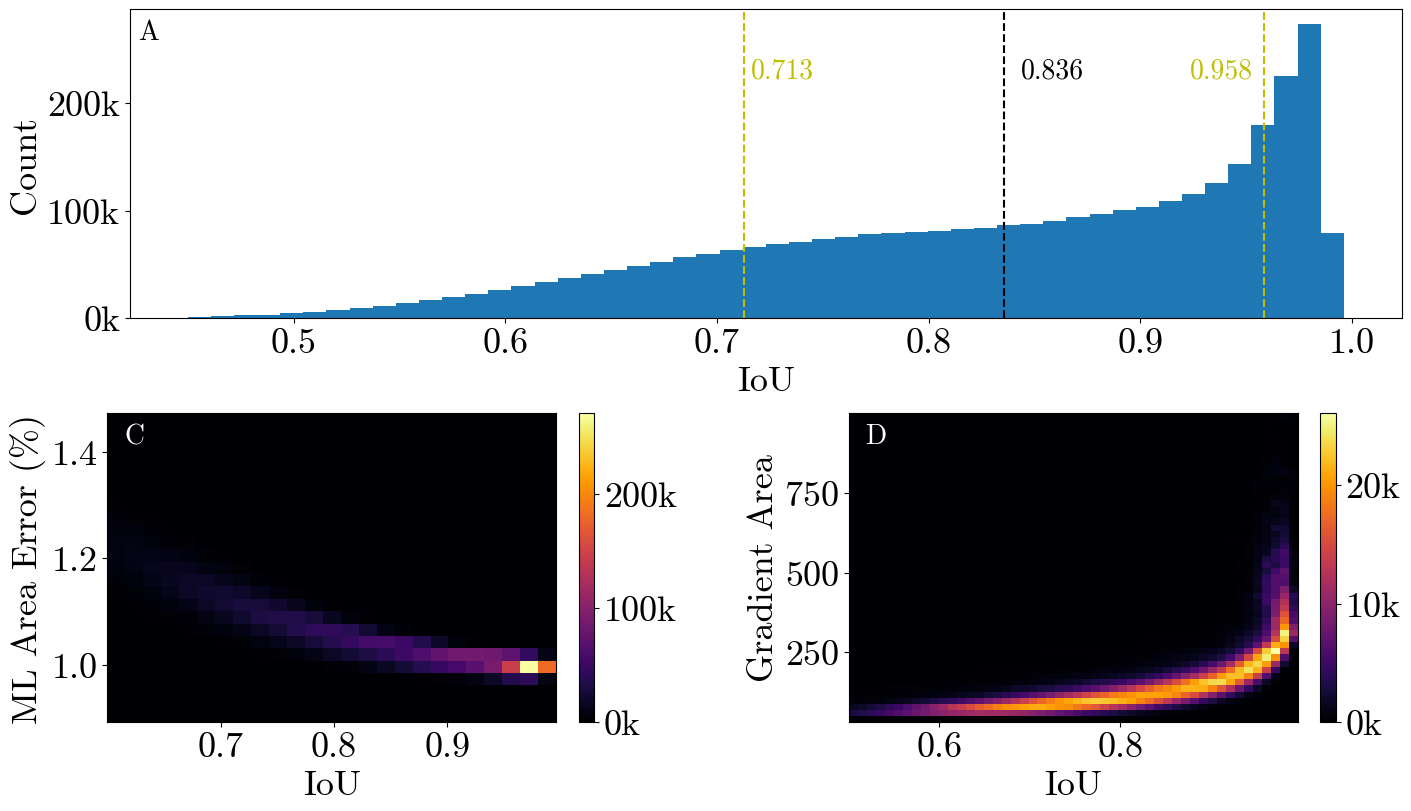

In [169]:
fourier_df_cropped = fourier_df[fourier_df['area_gradient'] < 1000]

# ------------------------------ HEATMAP ------------------------------
fig = plt.figure(layout="constrained", figsize=(14, 8),)
subfigs = fig.subfigures(nrows=2, ncols=1, )#wspace=0.07, width_ratios=[1.5, 1.])
# subfigs = fig.subfigures(nrows=2, ncols=2, hspace=0.05)#wspace=0.07, width_ratios=[1.5, 1.])
# (axs0, axs1) = fig.subplots(nrows=2, ncols=2, ) 
axs0 = subfigs[0].subplots(1,1)

# ------- Top 1 ------- 
fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['IoU'] > 0.45)]
axs0.hist(fourier_df_cropped_area['IoU'], 50, label=f"", rasterized=True) 
axs0.set(xlabel="IoU", ylabel="Count")
m = fourier_df['IoU'].mean()
sd = fourier_df['IoU'].std()
print(f"Mean: {np.round(m,3)} Std: {np.round(sd,3)}")
axs0.axvline(m, color='k', linestyle='dashed') 
axs0.axvline(m + sd, color='y', linestyle='dashed') 
axs0.axvline(m - sd, color='y', linestyle='dashed')

axs0.text(m-0.11, .8, np.round(m,3), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes, color='Black')
axs0.text(m-sd -0.2, .8, np.round(m-sd,3), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes, color='y')
axs0.text(m+sd -0.1, .8, np.round(m+sd,3), fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes, color='y')

# axs1[0].legend(loc='upper right', fontsize=18)
axs0.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))

# ---- Bottom three ----
axs1 = subfigs[1].subplots(1, 2, gridspec_kw={'wspace':0.1})# sharey=True)

# Lower left
# fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['IoU'] > 0.5)]
# im0 = axs1[0].hist2d(fourier_df_cropped_area['IoU'], fourier_df_cropped_area['gradient_eccentricity'], label=f"ALL", bins=25, cmap=plt.colormaps["inferno"], rasterized=True)
# axs1[0].set(xlabel="IoU", ylabel="gradient_eccentricity")

# # Lower middle
fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['IoU'] > 0.6)]
im0 = axs1[0].hist2d(fourier_df_cropped_area['IoU'], fourier_df_cropped_area['ML_area_error'], label=f"ALL", bins=25, cmap=plt.colormaps["inferno"], rasterized=True)
# axs1[1].set(xlabel="ML Area Error", ylabel="Gradient Area")
axs1[0].set_ylabel('ML Area Error (%)', fontsize = 26)
axs1[0].set_xlabel('IoU', fontsize = 26)
cbar = fig.colorbar(im0[3], ax=axs1[0], format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k"))
# axs1[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))


# ------- Lower right ------- 
fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['IoU'] > 0.5)]
im00 = axs1[1].hist2d(fourier_df_cropped_area['IoU'], fourier_df_cropped_area['area_gradient'], label=f"", bins=50, cmap=plt.colormaps["inferno"], rasterized=True)
cbar = fig.colorbar(im00[3], ax=axs1[1], format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k"))
# cbar.set_ticklabels([f"{int(a/1000)}k" for a in cbar.get_ticks()])
axs1[1].set(xlabel="IoU", ylabel="Gradient Area")

# # # Lower right
# fourier_df_cropped_area = fourier_df_cropped[(fourier_df_cropped['IoU'] > 0.6)]
# im12 = axs1[1].hist2d(fourier_df_cropped_area['IoU'], fourier_df_cropped_area['gradient_mean_intensity'], label=f"", bins=25, cmap=plt.colormaps["inferno"], rasterized=True) 
# axs1[1].set(xlabel="IoU", ylabel="Mean Intensity")
# cbar = fig.colorbar(im12[3], ax=axs1[1], format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k"))
# axs1[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '%1.0fk' % (x * 1e-3)))

axs0.text(.015, .925, 'A', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0.transAxes, color='Black')
# axs0[1].text(.04, .925, 'B', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs0[1].transAxes, color='white')
axs1[0].text(.06, .925, 'C', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[0].transAxes, color='White')
axs1[1].text(.06, .925, 'D', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[1].transAxes, color='white')
# axs1[2].text(.06, .925, 'E', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs1[2].transAxes, color='white')
# fig.subplots_adjust(wspace=10, hspace=10)
fig.savefig("D:/Master/MasterProject/Overleaf_figures/Chapter5/5.2/ML_Gradient_IoU.svg")   
fig.show()

In [77]:
fourier_df.columns

Index(['granule_ids', 'frames', 'area_gradient', 'area_ml', 'IoU',
       'gradient_mean_intensity', 'gradient_mean_radius',
       'gradient_major_axis', 'gradient_minor_axis', 'gradient_eccentricity',
       'ml_mean_intensity', 'ml_mean_radius', 'ml_major_axis', 'ml_minor_axis',
       'ml_eccentricity', 'granules_is_common', 'ml_exlusive',
       'gradient_exclusive', 'Gradient_valid', 'ML_valid',
       'Granules_in_common_count', 'Gradient_exclusive_count',
       'ML_exlusive_count', 'file', 'file_name', 'ML_area_error'],
      dtype='object')